In [ ]:
# Trains a sentiment analysis model to classify movie reviews as positive or negative, based on the text of the review.
# https://www.tensorflow.org/tutorials/text/classify_text_with_bert
# https://analyticsindiamag.com/bert-classifier-with-tensorflow-2-0/
#
# EXAMPLE: https://stackabuse.com/text-classification-with-bert-tokenizer-and-tf-2-0-in-python/
# Data: https://www.kaggle.com/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews

In [ ]:
# Install some dependencies
!pip install -q tensorflow-text  # A dependency of the preprocessing for BERT inputs
!pip install -q tf-models-official # For the AdamW optimizer from tensorflow/models
!pip install bert-for-tf2
!pip install sentencepiece

     |████████████████████████████████| 3.4MB 18.3MB/s 
     |████████████████████████████████| 1.1MB 15.4MB/s 
     |████████████████████████████████| 37.6MB 81kB/s 
     |████████████████████████████████| 51kB 7.6MB/s 
     |████████████████████████████████| 358kB 52.9MB/s 
     |████████████████████████████████| 645kB 48.1MB/s 
     |████████████████████████████████| 102kB 13.5MB/s 
     |████████████████████████████████| 174kB 55.2MB/s 
     |████████████████████████████████| 1.2MB 46.1MB/s 
     |████████████████████████████████| 706kB 48.7MB/s 
     |████████████████████████████████| 51kB 7.6MB/s 
  Created wheel for bert-for-tf2: filename=bert_for_tf2-0.14.9-cp37-none-any.whl size=30535 sha256=ec6207d3a0a31e975d770700b2d5c2ade1ffbc731704726b9edd67505d1b054b
  Stored in directory: /root/.cache/pip/wheels/a1/04/ee/347bd9f5b821b637c76411d280271a857aece00358896a230f
  Created wheel for py-params: filename=py_params-0.10.2-cp37-none-any.whl size=7912 sha256=9638855f7921b47fe295f5b36a

In [ ]:
import os
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
from sklearn.model_selection import train_test_split

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization  # to create AdamW optmizer
tf.get_logger().setLevel('ERROR')

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Embedding, SimpleRNN, LSTM, Bidirectional, Dense, Dropout

# Section 1: Load data

In [ ]:
# Load data and remove empty entries. Use only 10k
movie_reviews = pd.read_csv("IMDB_Dataset.csv")
movie_reviews.dropna(inplace=True)
movie_reviews = movie_reviews
movie_reviews

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
...,...,...
49995,I thought this movie did a down right good job...,positive
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",negative
49997,I am a Catholic taught in parochial elementary...,negative
49998,I'm going to have to disagree with the previou...,negative


In [ ]:
# Cleaning
TAG_RE = re.compile(r'<[^>]+>')
def preprocess_text(sen):
  """
  """
  sentence = TAG_RE.sub('', sen) # html tags
  sentence = re.sub('[^a-zA-Z]', ' ', sentence) # punctuations and numbers
  sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence) # single character
  sentence = re.sub(r'\s+', ' ', sentence) # multiple spaces
  return sentence.lower()

In [ ]:
# Clean and preprocess text (encode as bytestrings for processing by tf)
sentences = list(movie_reviews['review'])
reviews = np.array([str.encode(preprocess_text(sen)) for sen in sentences], dtype=object)

print(reviews.shape)
reviews[:5]

(50000,)


array([b'one of the other reviewers has mentioned that after watching just oz episode you ll be hooked they are right as this is exactly what happened with me the first thing that struck me about oz was its brutality and unflinching scenes of violence which set in right from the word go trust me this is not show for the faint hearted or timid this show pulls no punches with regards to drugs sex or violence its is hardcore in the classic use of the word it is called oz as that is the nickname given to the oswald maximum security state penitentary it focuses mainly on emerald city an experimental section of the prison where all the cells have glass fronts and face inwards so privacy is not high on the agenda em city is home to many aryans muslims gangstas latinos christians italians irish and more so scuffles death stares dodgy dealings and shady agreements are never far away would say the main appeal of the show is due to the fact that it goes where other shows wouldn dare forget pretty

In [ ]:
# Put sentiments into class form {0, 1}
y = movie_reviews['sentiment']
y = np.array(list(map(lambda x: 1 if x=="positive" else 0, y)), dtype='int32')

print(y.shape)
print(y[:20])

(50000,)
[1 1 1 0 1 1 1 0 0 1 0 0 0 0 1 0 1 0 1 0]


In [ ]:
# Split train test
x_train, x_test, y_train, y_test = train_test_split(reviews, y, test_size=0.2)

print(x_train.shape)
print(x_test.shape)
print(y_train.sum())
print(y_test.sum())

(40000,)
(10000,)
19998
5002


In [ ]:
# DEFINE BERT models for preporcessing and embedding
tfhub_handle_preprocess = "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3"
tfhub_handle_encoder = "https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1"

# Section 2: RNN

In [ ]:
# Create RNN model
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text') #input layer

preprocessor = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing') #BERT tokenizer
tokenized = preprocessor(text_input)
tokens = tokenized['input_word_ids'] #BERT returns tokens, mask, and sentence index. Keep only the tokens

h = tf.keras.layers.Embedding(input_length=128, input_dim=30000, output_dim=64, trainable=True)(tokens)
h = tf.keras.layers.Dropout(0.1)(h)
h = tf.keras.layers.SimpleRNN(units=32)(h)
h = tf.keras.layers.Dropout(0.1)(h)
o = tf.keras.layers.Dense(1, activation=None, name='classifier')(h)

model_RNN = tf.keras.Model(text_input, o)
model_RNN.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text (InputLayer)            [(None,)]                 0         
_________________________________________________________________
preprocessing (KerasLayer)   {'input_mask': (None, 128 0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 128, 64)           1920000   
_________________________________________________________________
dropout (Dropout)            (None, 128, 64)           0         
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 32)                3104      
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
classifier (Dense)           (None, 1)                 33  

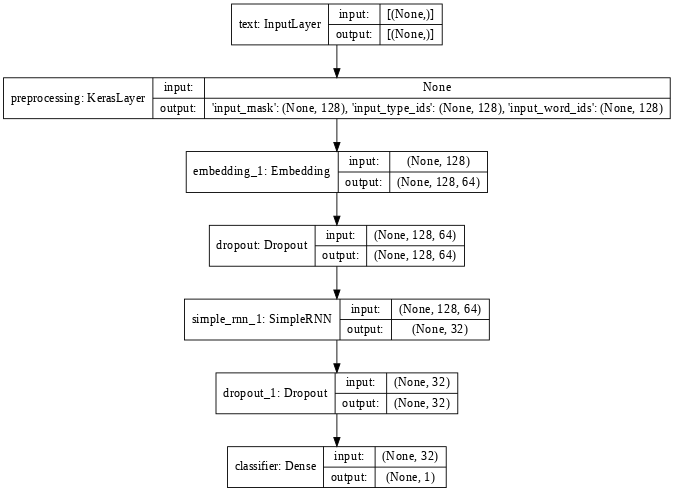

In [ ]:
# Plot model
tf.keras.utils.plot_model(model_RNN, show_shapes=True, show_layer_names=True, dpi=64)

In [ ]:
# Compile
model_RNN.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), optimizer='adam', metrics=[tf.metrics.BinaryAccuracy()])
history = model_RNN.fit(x=x_train, y=y_train, epochs=10, batch_size=64, validation_split=0.1)

Epoch 1/10
563/563 [==============================] - 149s 263ms/step - loss: 0.6801 - binary_accuracy: 0.5269 - val_loss: 0.5867 - val_binary_accuracy: 0.7205
Epoch 2/10
563/563 [==============================] - 149s 264ms/step - loss: 0.5585 - binary_accuracy: 0.7031 - val_loss: 0.5225 - val_binary_accuracy: 0.7753
Epoch 3/10
563/563 [==============================] - 148s 263ms/step - loss: 0.3999 - binary_accuracy: 0.8364 - val_loss: 0.6734 - val_binary_accuracy: 0.6100
Epoch 4/10
563/563 [==============================] - 148s 263ms/step - loss: 0.3026 - binary_accuracy: 0.8762 - val_loss: 0.5986 - val_binary_accuracy: 0.7563
Epoch 5/10
563/563 [==============================] - 148s 263ms/step - loss: 0.3850 - binary_accuracy: 0.8128 - val_loss: 0.9767 - val_binary_accuracy: 0.5192
Epoch 6/10
563/563 [==============================] - 148s 263ms/step - loss: 0.2087 - binary_accuracy: 0.8935 - val_loss: 1.1925 - val_binary_accuracy: 0.5230
Epoch 7/10
563/563 [====================

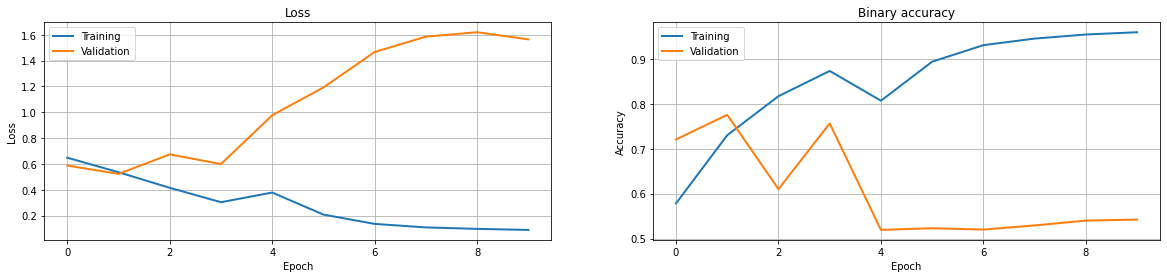

In [ ]:
# Plot loss
plt.figure(figsize=(20, 4))

plt.subplot(1, 2, 1)
plt.title('Loss')
plt.plot(history.history['loss'], label='Training', linewidth=2)
plt.plot(history.history['val_loss'], label='Validation', linewidth=2)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.title('Binary accuracy')
plt.plot(history.history['binary_accuracy'], label='Training', linewidth=2)
plt.plot(history.history['val_binary_accuracy'], label='Validation', linewidth=2)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)

plt.show()

In [ ]:
# Evaluate on test set
loss, accuracy = model_RNN.evaluate(x_test, y_test)

print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')

313/313 [==============================] - 20s 64ms/step - loss: 1.5324 - binary_accuracy: 0.5504
Loss: 1.532402753829956
Accuracy: 0.5504000186920166


# Section 3: LSTM

In [ ]:
# Create LSTM model
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text') #input layer

preprocessor = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing') #BERT tokenizer
tokenized = preprocessor(text_input)
tokens = tokenized['input_word_ids'] #BERT returns tokens, mask, and sentence index. Keep only the tokens

h = tf.keras.layers.Embedding(input_length=128, input_dim=30000, output_dim=64, trainable=True)(tokens)
h = tf.keras.layers.LSTM(units=32)(h)
o = tf.keras.layers.Dense(1, activation=None, name='classifier')(h)

model_LSTM = tf.keras.Model(text_input, o)
model_LSTM.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text (InputLayer)            [(None,)]                 0         
_________________________________________________________________
preprocessing (KerasLayer)   {'input_mask': (None, 128 0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 128, 64)           1920000   
_________________________________________________________________
lstm (LSTM)                  (None, 32)                12416     
_________________________________________________________________
classifier (Dense)           (None, 1)                 33        
Total params: 1,932,449
Trainable params: 1,932,449
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Compile
model_LSTM.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), optimizer='adam', metrics=[tf.metrics.BinaryAccuracy()])
history = model_LSTM.fit(x_train, y_train, epochs=10, batch_size=64, validation_split=0.1)

Epoch 1/10
563/563 [==============================] - 118s 204ms/step - loss: 0.5466 - binary_accuracy: 0.6644 - val_loss: 0.3504 - val_binary_accuracy: 0.8415
Epoch 2/10
563/563 [==============================] - 115s 205ms/step - loss: 0.2576 - binary_accuracy: 0.8973 - val_loss: 0.3573 - val_binary_accuracy: 0.8520
Epoch 3/10
563/563 [==============================] - 115s 205ms/step - loss: 0.1807 - binary_accuracy: 0.9352 - val_loss: 0.4352 - val_binary_accuracy: 0.8353
Epoch 4/10
563/563 [==============================] - 115s 205ms/step - loss: 0.1242 - binary_accuracy: 0.9553 - val_loss: 0.5206 - val_binary_accuracy: 0.8407
Epoch 5/10
563/563 [==============================] - 115s 205ms/step - loss: 0.0898 - binary_accuracy: 0.9681 - val_loss: 0.5077 - val_binary_accuracy: 0.8395
Epoch 6/10
563/563 [==============================] - 116s 205ms/step - loss: 0.0660 - binary_accuracy: 0.9783 - val_loss: 0.7118 - val_binary_accuracy: 0.8367
Epoch 7/10
563/563 [====================

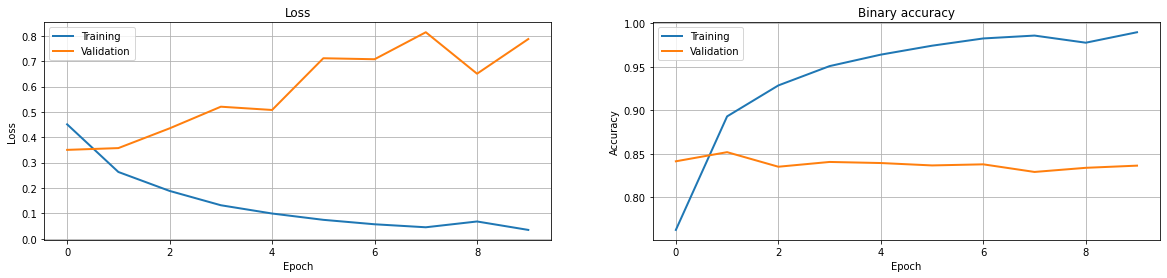

In [ ]:
# Plot loss
plt.figure(figsize=(20, 4))

plt.subplot(1, 2, 1)
plt.title('Loss')
plt.plot(history.history['loss'], label='Training', linewidth=2)
plt.plot(history.history['val_loss'], label='Validation', linewidth=2)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.title('Binary accuracy')
plt.plot(history.history['binary_accuracy'], label='Training', linewidth=2)
plt.plot(history.history['val_binary_accuracy'], label='Validation', linewidth=2)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)

plt.show()

In [ ]:
# Evaluate on test set
loss, accuracy = model_LSTM.evaluate(x_test, y_test)

print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')

313/313 [==============================] - 20s 62ms/step - loss: 0.8322 - binary_accuracy: 0.8307
Loss: 0.8322371244430542
Accuracy: 0.8306999802589417


# Section 4: Bidirectional LSTM

In [ ]:
# Create LSTM model
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text') #input layer

preprocessor = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing') #BERT tokenizer
tokenized = preprocessor(text_input)
tokens = tokenized['input_word_ids'] #BERT returns tokens, mask, and sentence index. Keep only the tokens

h = Embedding(input_length=128, input_dim=30000, output_dim=64, trainable=True)(tokens)
h = Dropout(0.1)(h)
h = Bidirectional(LSTM(units=32))(h)
h = Dropout(0.1)(h)
o = Dense(1, activation=None, name='classifier')(h)

model_BiLSTM = tf.keras.Model(text_input, o)
model_BiLSTM.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text (InputLayer)            [(None,)]                 0         
_________________________________________________________________
preprocessing (KerasLayer)   {'input_type_ids': (None, 0         
_________________________________________________________________
embedding_4 (Embedding)      (None, 128, 64)           1920000   
_________________________________________________________________
dropout_5 (Dropout)          (None, 128, 64)           0         
_________________________________________________________________
bidirectional (Bidirectional (None, 64)                24832     
_________________________________________________________________
dropout_6 (Dropout)          (None, 64)                0         
_________________________________________________________________
classifier (Dense)           (None, 1)                 65  

In [ ]:
# Compile
model_BiLSTM.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), optimizer='adam', metrics=[tf.metrics.BinaryAccuracy()])
history = model_BiLSTM.fit(x_train, y_train, epochs=10, batch_size=64, validation_split=0.1)

Epoch 1/10
563/563 [==============================] - 123s 213ms/step - loss: 0.5273 - binary_accuracy: 0.6912 - val_loss: 0.3589 - val_binary_accuracy: 0.8303
Epoch 2/10
563/563 [==============================] - 119s 212ms/step - loss: 0.2549 - binary_accuracy: 0.8960 - val_loss: 0.3716 - val_binary_accuracy: 0.8475
Epoch 3/10
563/563 [==============================] - 119s 212ms/step - loss: 0.1747 - binary_accuracy: 0.9332 - val_loss: 0.3918 - val_binary_accuracy: 0.8428
Epoch 4/10
563/563 [==============================] - 119s 212ms/step - loss: 0.1304 - binary_accuracy: 0.9525 - val_loss: 0.4470 - val_binary_accuracy: 0.8335
Epoch 5/10
563/563 [==============================] - 119s 212ms/step - loss: 0.1057 - binary_accuracy: 0.9615 - val_loss: 0.5617 - val_binary_accuracy: 0.8338
Epoch 6/10
563/563 [==============================] - 120s 213ms/step - loss: 0.0810 - binary_accuracy: 0.9715 - val_loss: 0.6193 - val_binary_accuracy: 0.8350
Epoch 7/10
563/563 [====================

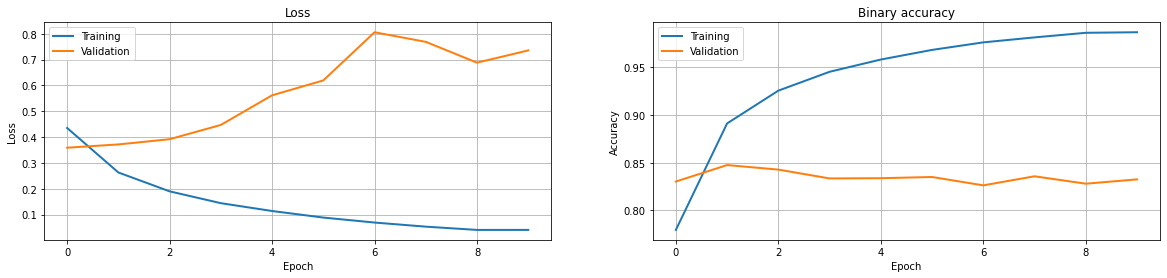

In [ ]:
# Plot loss
plt.figure(figsize=(20, 4))

plt.subplot(1, 2, 1)
plt.title('Loss')
plt.plot(history.history['loss'], label='Training', linewidth=2)
plt.plot(history.history['val_loss'], label='Validation', linewidth=2)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.title('Binary accuracy')
plt.plot(history.history['binary_accuracy'], label='Training', linewidth=2)
plt.plot(history.history['val_binary_accuracy'], label='Validation', linewidth=2)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)

plt.show()

In [ ]:
# Evaluate on test set
loss, accuracy = model_BiLSTM.evaluate(x_test, y_test)

print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')

313/313 [==============================] - 21s 68ms/step - loss: 0.7353 - binary_accuracy: 0.8304
Loss: 0.7352562546730042
Accuracy: 0.8303999900817871


# Section 5: BERT

In [ ]:
# Build Neural Network with BERT
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text') #input

preprocessor = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing') #BERT tokenizer
tokenized = preprocessor(text_input)

encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder') #BERT embedding and encoding
embedded = encoder(tokenized)

net = embedded['pooled_output']
net = tf.keras.layers.Dropout(0.1)(net)
net = tf.keras.layers.Dense(32, activation='relu',)(net)
net = tf.keras.layers.Dropout(0.1)(net)
net = tf.keras.layers.Dense(1, activation=None, name='classifier')(net)

model_BERT = tf.keras.Model(text_input, net)
model_BERT.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
text (InputLayer)               [(None,)]            0                                            
__________________________________________________________________________________________________
preprocessing (KerasLayer)      {'input_word_ids': ( 0           text[0][0]                       
__________________________________________________________________________________________________
BERT_encoder (KerasLayer)       {'encoder_outputs':  28763649    preprocessing[0][0]              
                                                                 preprocessing[0][1]              
                                                                 preprocessing[0][2]              
____________________________________________________________________________________________

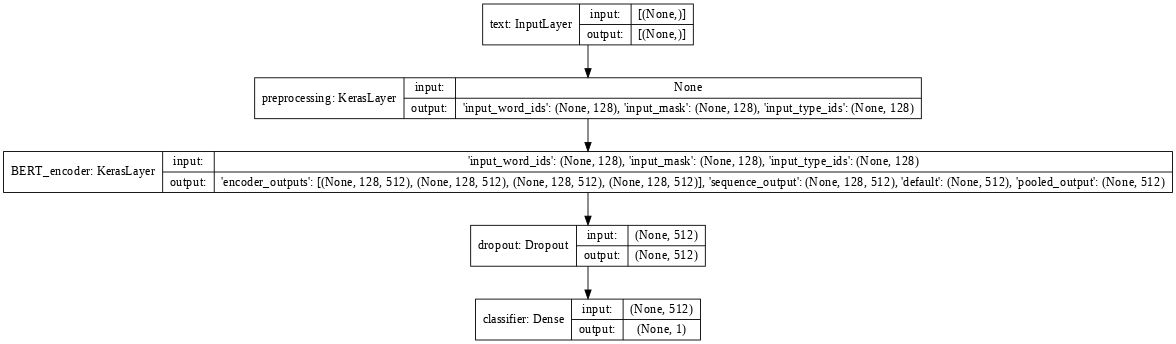

In [ ]:
# Plot it
tf.keras.utils.plot_model(model_BERT, show_shapes=True, show_layer_names=True, dpi=64)

In [ ]:
# Custom compilation
epochs = 5
steps_per_epoch = 500
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

model_BERT.compile(optimizer=optimizer,
                         loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                         metrics=tf.metrics.BinaryAccuracy())

In [ ]:
# Training
history = model_BERT.fit(x=x_train, y=y_train, epochs=10, validation_split=0.1)

Epoch 1/10
1125/1125 [==============================] - 262s 228ms/step - loss: 0.5370 - binary_accuracy: 0.7020 - val_loss: 0.3385 - val_binary_accuracy: 0.8675
Epoch 2/10
1125/1125 [==============================] - 259s 230ms/step - loss: 0.2943 - binary_accuracy: 0.8747 - val_loss: 0.3023 - val_binary_accuracy: 0.8755
Epoch 3/10
1125/1125 [==============================] - 259s 231ms/step - loss: 0.2381 - binary_accuracy: 0.9021 - val_loss: 0.3073 - val_binary_accuracy: 0.8777
Epoch 4/10
1125/1125 [==============================] - 259s 231ms/step - loss: 0.2345 - binary_accuracy: 0.9029 - val_loss: 0.3073 - val_binary_accuracy: 0.8777
Epoch 5/10
1125/1125 [==============================] - 261s 232ms/step - loss: 0.2359 - binary_accuracy: 0.9035 - val_loss: 0.3073 - val_binary_accuracy: 0.8777
Epoch 6/10
1125/1125 [==============================] - 261s 232ms/step - loss: 0.2341 - binary_accuracy: 0.9015 - val_loss: 0.3073 - val_binary_accuracy: 0.8777
Epoch 7/10
1125/1125 [======

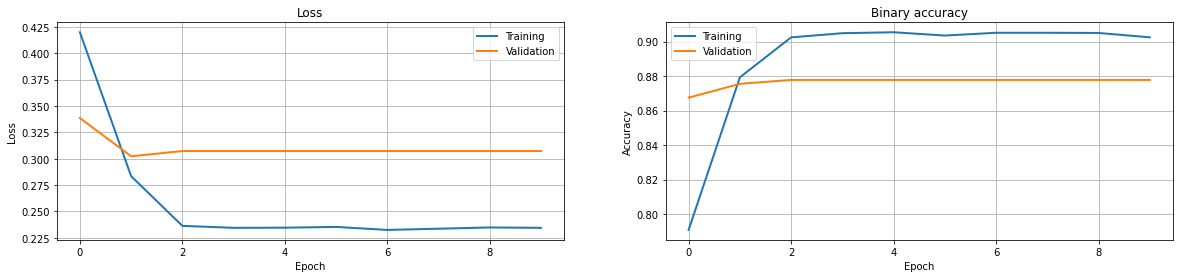

In [ ]:
# Plot loss
plt.figure(figsize=(20, 4))

plt.subplot(1, 2, 1)
plt.title('Loss')
plt.plot(history.history['loss'], label='Training', linewidth=2)
plt.plot(history.history['val_loss'], label='Validation', linewidth=2)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.title('Binary accuracy')
plt.plot(history.history['binary_accuracy'], label='Training', linewidth=2)
plt.plot(history.history['val_binary_accuracy'], label='Validation', linewidth=2)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)

plt.show()

In [ ]:
# Evaluate on test set
loss, accuracy = model_BERT.evaluate(x_test, y_test)

print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')

313/313 [==============================] - 32s 102ms/step - loss: 0.3325 - binary_accuracy: 0.8692
Loss: 0.33245354890823364
Accuracy: 0.8691999912261963
